In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import anndata
import geopandas as gpd
import scanpy as sc

from tifffile import imread, imwrite
from csbdeep.utils import normalize
from stardist.models import StarDist2D
from shapely.geometry import Polygon, Point
from scipy import sparse
from matplotlib.colors import ListedColormap

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# Load the image file
# Change dir_base as needed to the directory where the downloaded example data is stored
dir_base = '/media/whc/02C401E8C401DF33/zt/10x/outs/'
filename = '13.5b-16.5E-15.5E-14.5E-P1.tif'
img = imread(dir_base + filename)

2025-04-13 21:10:07.501203: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-13 21:10:07.514239: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1744549807.529058  550064 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744549807.534007  550064 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-04-13 21:10:07.550424: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

Attempting to memory-map TIFF: /media/whc/02C401E8C401DF33/zt/10x/outs/13.5b-16.5E-15.5E-14.5E-P1.tif
Page shape: (35908, 30034, 3), dtype: uint8
Accessing page data (may take a moment)...
Accessed data array (potentially memory-mapped) in 4.52 seconds.
Data array loaded into memory (check available RAM).

Reading top-left 1000x1000 chunk from array...
Reading bottom-left 1000x1000 chunk from array...
Finished reading chunks in 4.70 seconds total.


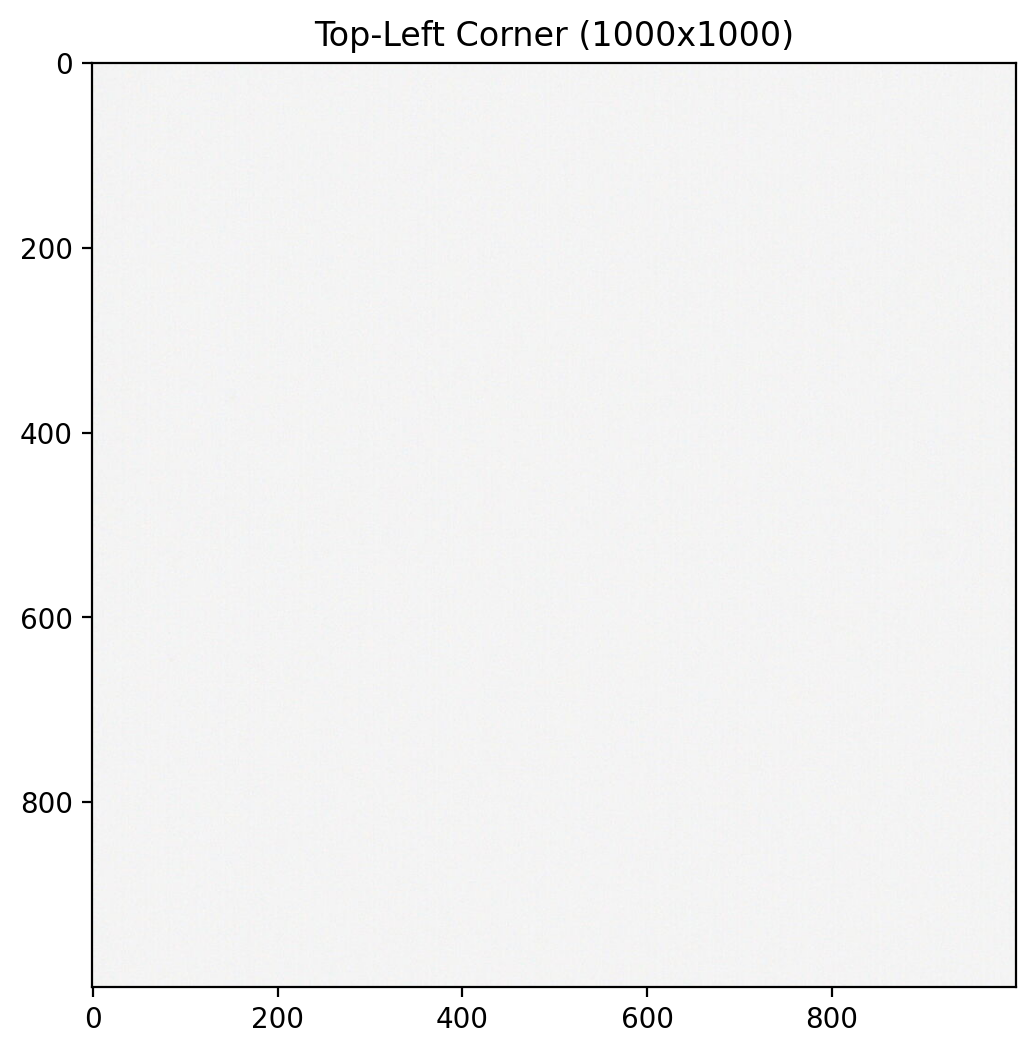

Top-Left Chunk - Mean: 244.02, Min: 234, Max: 254


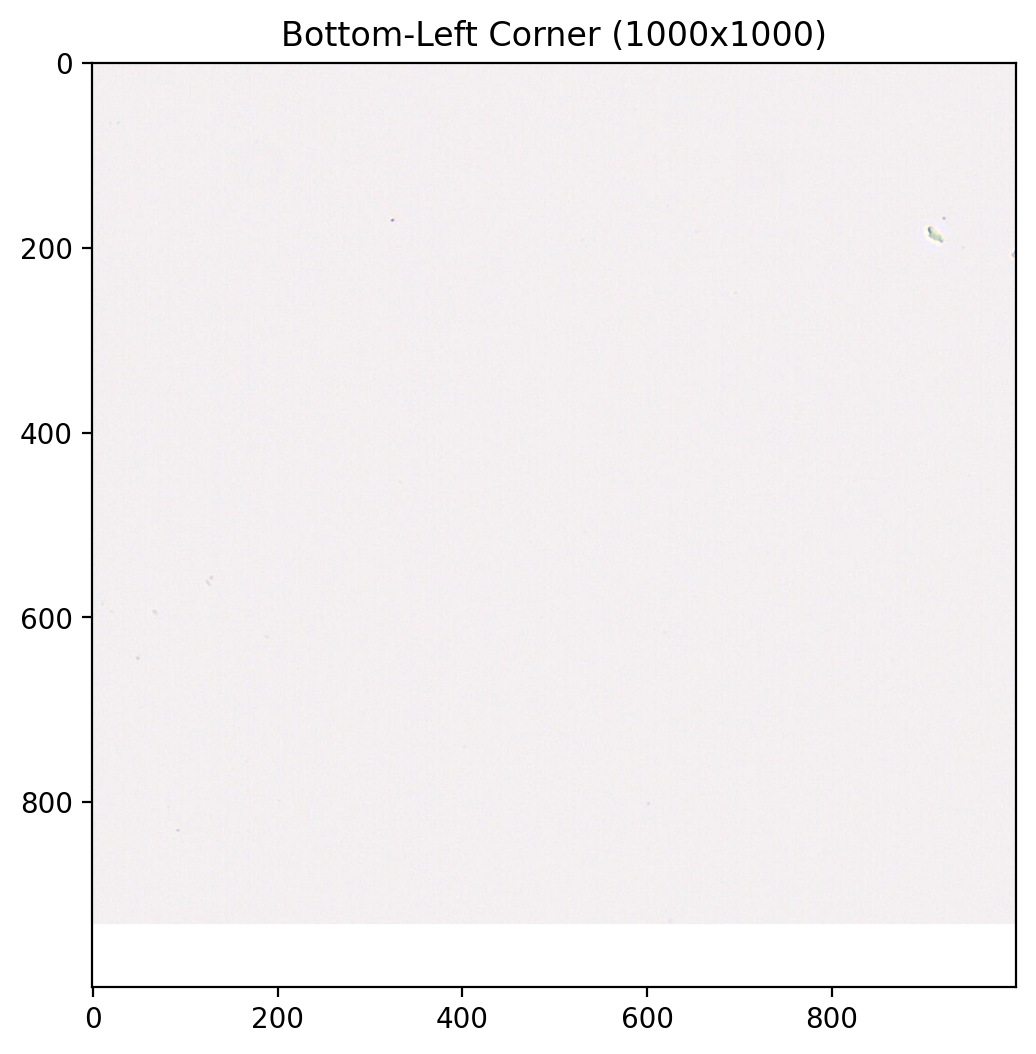

Bottom-Left Chunk - Mean: 242.49, Min: 92, Max: 255


In [6]:
import tifffile
import numpy as np
import matplotlib.pyplot as plt
import time # To time the operation

filepath = '/media/whc/02C401E8C401DF33/zt/10x/outs/13.5b-16.5E-15.5E-14.5E-P1.tif' # <<< Your actual path

try:
    print(f"Attempting to memory-map TIFF: {filepath}")
    start_time = time.time()
    with tifffile.TiffFile(filepath) as tif:
        # Access the first (and only) page
        page = tif.pages[0]
        print(f"Page shape: {page.shape}, dtype: {page.dtype}")

        # Get the data as a NumPy array - likely memory-mapped for large files
        # We don't use the 'slice' keyword here
        print("Accessing page data (may take a moment)...")
        data = page.asarray()
        load_time = time.time() - start_time
        print(f"Accessed data array (potentially memory-mapped) in {load_time:.2f} seconds.")
        # Check if it's actually memory mapped (optional)
        if isinstance(data, np.memmap):
             print("Data array is memory-mapped.")
        else:
             print("Data array loaded into memory (check available RAM).") # Less likely for huge file

        # Now SLICE the NumPy array (this should be efficient if memory-mapped)
        chunk_size = 1000 # How many pixels to read from corners
        print(f"\nReading top-left {chunk_size}x{chunk_size} chunk from array...")
        top_left_chunk = data[0:chunk_size, 0:chunk_size, :]

        print(f"Reading bottom-left {chunk_size}x{chunk_size} chunk from array...")
        # Get the total height from the shape
        height = data.shape[0]
        bottom_left_chunk = data[height-chunk_size:height, 0:chunk_size, :]

        end_time = time.time()
        print(f"Finished reading chunks in {end_time - start_time:.2f} seconds total.")

        # --- Display the top-left chunk ---
        plt.figure(figsize=(6,6))
        plt.imshow(top_left_chunk)
        plt.title(f"Top-Left Corner ({chunk_size}x{chunk_size})")
        plt.show()
        # Check if it looks like padding
        print(f"Top-Left Chunk - Mean: {np.mean(top_left_chunk):.2f}, Min: {np.min(top_left_chunk)}, Max: {np.max(top_left_chunk)}")


        # --- Display the bottom-left chunk ---
        plt.figure(figsize=(6,6))
        plt.imshow(bottom_left_chunk)
        plt.title(f"Bottom-Left Corner ({chunk_size}x{chunk_size})")
        plt.show()
        # Check if it looks like padding
        print(f"Bottom-Left Chunk - Mean: {np.mean(bottom_left_chunk):.2f}, Min: {np.min(bottom_left_chunk)}, Max: {np.max(bottom_left_chunk)}")


except FileNotFoundError:
    print(f"ERROR: File not found at {filepath}")
except Exception as e:
    print(f"An error occurred: {e}")
    import traceback
    traceback.print_exc() # Print detailed traceback

In [2]:
# General image plotting functions
def plot_mask_and_save_image(title, gdf, img, cmap, output_name=None, bbox=None):
    if bbox is not None:
        # Crop the image to the bounding box
        cropped_img = img[bbox[1]:bbox[3], bbox[0]:bbox[2]]
    else:
        cropped_img = img

    # Plot options
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))

    # Plot the cropped image
    axes[0].imshow(cropped_img, cmap='gray', origin='lower')
    axes[0].set_title(title)
    axes[0].axis('off')

    # Create filtering polygon
    if bbox is not None:
        bbox_polygon = Polygon([(bbox[0], bbox[1]), (bbox[2], bbox[1]), (bbox[2], bbox[3]), (bbox[0], bbox[3])])
        # Filter for polygons in the box
        intersects_bbox = gdf['geometry'].intersects(bbox_polygon)
        filtered_gdf = gdf[intersects_bbox]
    else:
        filtered_gdf=gdf

    # Plot the filtered polygons on the second axis
    filtered_gdf.plot(cmap=cmap, ax=axes[1])
    axes[1].axis('off')
    axes[1].legend(loc='upper left', bbox_to_anchor=(1.05, 1))


    # Save the plot if output_name is provided
    if output_name is not None:
        plt.savefig(output_name, bbox_inches='tight')  # Use bbox_inches='tight' to include the legend
    else:
        plt.show()

def plot_gene_and_save_image(title, gdf, gene, img, adata, bbox=None, output_name=None):

    if bbox is not None:
        # Crop the image to the bounding box
        cropped_img = img[bbox[1]:bbox[3], bbox[0]:bbox[2]]
    else:
        cropped_img = img

    # Plot options
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))

    # Plot the cropped image
    axes[0].imshow(cropped_img, cmap='gray', origin='lower')
    axes[0].set_title(title)
    axes[0].axis('off')

    # Create filtering polygon
    if bbox is not None:
        bbox_polygon = Polygon([(bbox[0], bbox[1]), (bbox[2], bbox[1]), (bbox[2], bbox[3]), (bbox[0], bbox[3])])


    # Find a gene of interest and merge with the geodataframe
    gene_expression = adata[:, gene].to_df()
    gene_expression['id'] = gene_expression.index
    merged_gdf = gdf.merge(gene_expression, left_on='id', right_on='id')

    if bbox is not None:
        # Filter for polygons in the box
        intersects_bbox = merged_gdf['geometry'].intersects(bbox_polygon)
        filtered_gdf = merged_gdf[intersects_bbox]
    else:
        filtered_gdf = merged_gdf

    # Plot the filtered polygons on the second axis
    filtered_gdf.plot(column=gene, cmap='inferno', legend=True, ax=axes[1])
    axes[1].set_title(gene)
    axes[1].axis('off')
    axes[1].legend(loc='upper left', bbox_to_anchor=(1.05, 1))

    # Save the plot if output_name is provided
    if output_name is not None:
        plt.savefig(output_name, bbox_inches='tight')  # Use bbox_inches='tight' to include the legend
    else:
        plt.show()

def plot_clusters_and_save_image(title, gdf, img, adata, bbox=None, color_by_obs=None, output_name=None, color_list=None):
    color_list=["#7f0000","#808000","#483d8b","#008000","#bc8f8f","#008b8b","#4682b4","#000080","#d2691e","#9acd32","#8fbc8f","#800080","#b03060","#ff4500","#ffa500","#ffff00","#00ff00","#8a2be2","#00ff7f","#dc143c","#00ffff","#0000ff","#ff00ff","#1e90ff","#f0e68c","#90ee90","#add8e6","#ff1493","#7b68ee","#ee82ee"]
    if bbox is not None:
        cropped_img = img[bbox[1]:bbox[3], bbox[0]:bbox[2]]
    else:
        cropped_img = img

    fig, axes = plt.subplots(1, 2, figsize=(12, 6))

    axes[0].imshow(cropped_img, cmap='gray', origin='lower')
    axes[0].set_title(title)
    axes[0].axis('off')

    if bbox is not None:
        bbox_polygon = Polygon([(bbox[0], bbox[1]), (bbox[2], bbox[1]), (bbox[2], bbox[3]), (bbox[0], bbox[3])])

    unique_values = adata.obs[color_by_obs].astype('category').cat.categories
    num_categories = len(unique_values)

    if color_list is not None and len(color_list) >= num_categories:
        custom_cmap = ListedColormap(color_list[:num_categories], name='custom_cmap')
    else:
        # Use default tab20 colors if color_list is insufficient
        tab20_colors = plt.cm.tab20.colors[:num_categories]
        custom_cmap = ListedColormap(tab20_colors, name='custom_tab20_cmap')

    merged_gdf = gdf.merge(adata.obs[color_by_obs].astype('category'), left_on='id', right_index=True)

    if bbox is not None:
        intersects_bbox = merged_gdf['geometry'].intersects(bbox_polygon)
        filtered_gdf = merged_gdf[intersects_bbox]
    else:
        filtered_gdf = merged_gdf

    # Plot the filtered polygons on the second axis
    plot = filtered_gdf.plot(column=color_by_obs, cmap=custom_cmap, ax=axes[1], legend=True)
    axes[1].set_title(color_by_obs)
    legend = axes[1].get_legend()
    legend.set_bbox_to_anchor((1.05, 1))
    axes[1].axis('off')

    # Move legend outside the plot
    plot.get_legend().set_bbox_to_anchor((1.25, 1))

    if output_name is not None:
        plt.savefig(output_name, bbox_inches='tight')
    else:
        plt.show()

# Plotting function for nuclei area distribution
def plot_nuclei_area(gdf,area_cut_off):
    fig, axs = plt.subplots(1, 2, figsize=(15, 4))
    # Plot the histograms
    axs[0].hist(gdf['area'], bins=50, edgecolor='black')
    axs[0].set_title('Nuclei Area')

    axs[1].hist(gdf[gdf['area'] < area_cut_off]['area'], bins=50, edgecolor='black')
    axs[1].set_title('Nuclei Area Filtered:'+str(area_cut_off))

    plt.tight_layout()
    plt.show()

# Total UMI distribution plotting function
def total_umi(adata_, cut_off):
    fig, axs = plt.subplots(1, 2, figsize=(12, 4))

    # Box plot
    axs[0].boxplot(adata_.obs["total_counts"], vert=False, widths=0.7, patch_artist=True, boxprops=dict(facecolor='skyblue'))
    axs[0].set_title('Total Counts')

    # Box plot after filtering
    axs[1].boxplot(adata_.obs["total_counts"][adata_.obs["total_counts"] > cut_off], vert=False, widths=0.7, patch_artist=True, boxprops=dict(facecolor='skyblue'))
    axs[1].set_title('Total Counts > ' + str(cut_off))

    # Remove y-axis ticks and labels
    for ax in axs:
        ax.get_yaxis().set_visible(False)

    plt.tight_layout()
    plt.show()


In [3]:
# Load the pretrained model
model = StarDist2D.from_pretrained('2D_versatile_he')

# Percentile normalization of the image
# Adjust min_percentile and max_percentile as needed
min_percentile = 5
max_percentile = 95
img = normalize(img, min_percentile, max_percentile)

Found model '2D_versatile_he' for 'StarDist2D'.


I0000 00:00:1744364759.932041 3125813 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5116 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1060 6GB, pci bus id: 0000:02:00.0, compute capability: 6.1


Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


In [4]:
# Predict cell nuclei using the normalized image
# Adjust nms_thresh and prob_thresh as needed
# Try with much smaller block size
labels, polys = model.predict_instances_big(
    img, 
    axes='YXC', 
    block_size=1024,  # Reduced from 4096
    prob_thresh=0.001,
    nms_thresh=0.001, 
    min_overlap=128, 
    context=128, 
    normalizer=None, 
    n_tiles=(2,2,1)   # Reduced from (4,4,1)
)


effective: block_size=(1024, 1024, 3), min_overlap=(128, 128, 0), context=(128, 128, 0)


functional.py (238): The structure of `inputs` doesn't match the expected structure.
Expected: ['input']
Received: inputs=Tensor(shape=(1, 256, 256, 3))
I0000 00:00:1744364788.895871 3126126 service.cc:148] XLA service 0x7fbbc000d270 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1744364788.895912 3126126 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce GTX 1060 6GB, Compute Capability 6.1
2025-04-11 17:46:28.931637: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1744364788.992523 3126126 cuda_dnn.cc:529] Loaded cuDNN version 90800
2025-04-11 17:46:29.213395: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{} for conv (f32[1,32,256,256]{3,2,1,0}, u8[0]{0}) custom-call(f32[1,3,256,256]{3,2,1,0}, f32[32,3,3,3]{3,2,1,0}, f32[32]{0}), wi

In [12]:
# Save both in a single file
import pickle
with open('stardist_results.pkl', 'wb') as f:
    pickle.dump({'labels': labels, 'polys': polys}, f)

In [3]:
import pickle
with open('stardist_results.pkl', 'rb') as f:
    results = pickle.load(f)
    labels = results['labels']
    polys = results['polys']

In [4]:
# Creating a list to store Polygon geometries
geometries = []

# Iterating through each nuclei in the 'polys' DataFrame
for nuclei in range(len(polys['coord'])):

    # Extracting coordinates for the current nuclei and converting them to (y, x) format
    coords = [(y, x) for x, y in zip(polys['coord'][nuclei][0], polys['coord'][nuclei][1])]

    # Creating a Polygon geometry from the coordinates
    geometries.append(Polygon(coords))

# Creating a GeoDataFrame using the Polygon geometries
gdf = gpd.GeoDataFrame(geometry=geometries)
gdf['id'] = [f"ID_{i+1}" for i, _ in enumerate(gdf.index)]


2541471591.py (29): No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


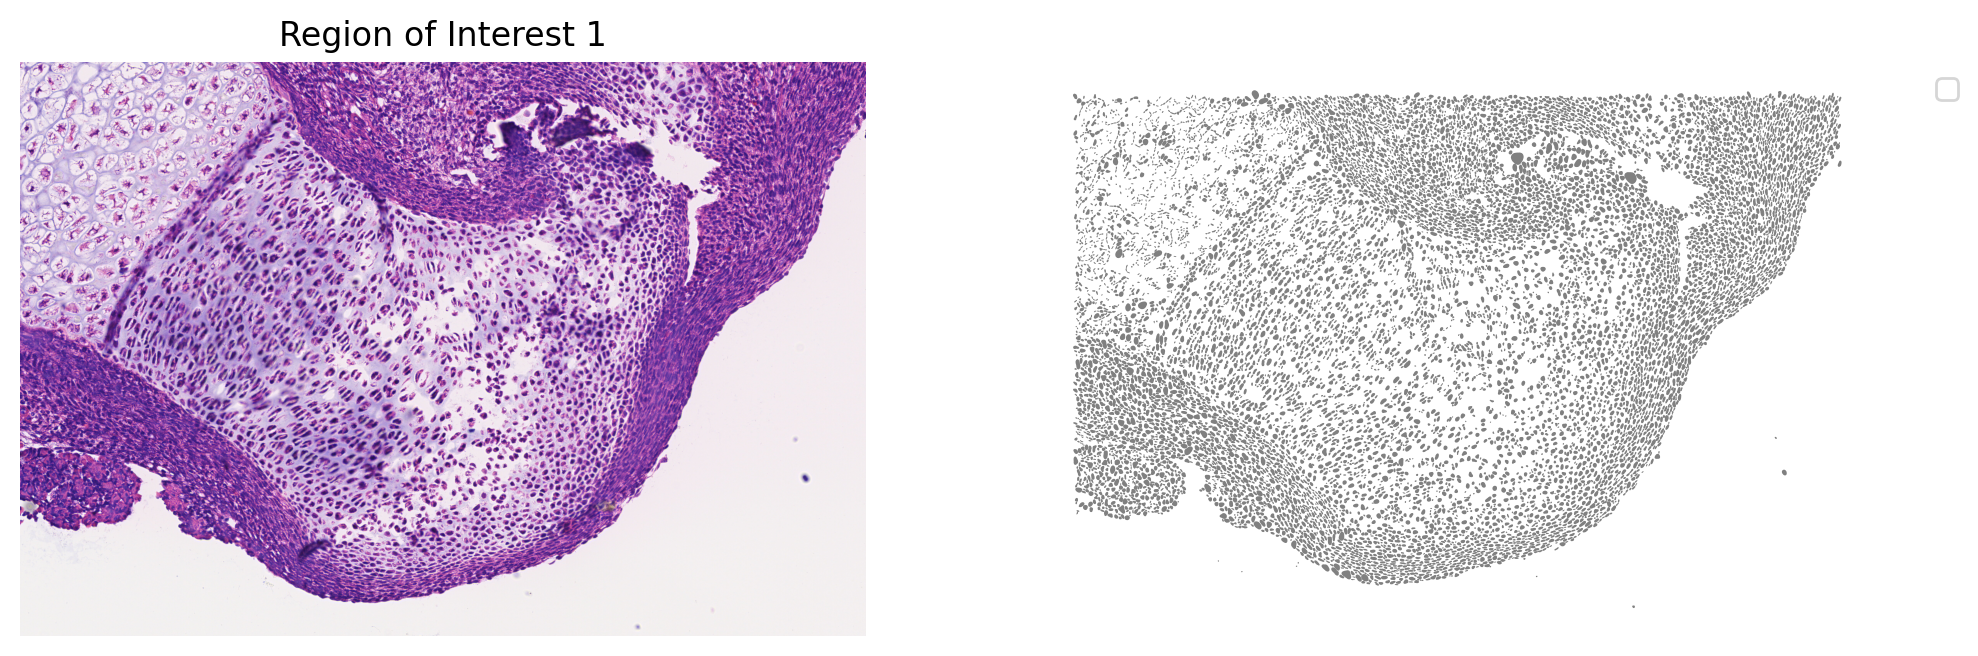

In [5]:
# Plot the nuclei segmentation
def plot_mask_and_save_image(title, gdf, img, cmap, output_name=None, bbox=None):
    if bbox is not None:
        # Crop the image to the bounding box
        cropped_img = img[bbox[1]:bbox[3], bbox[0]:bbox[2]]
    else:
        cropped_img = img

    # Plot options
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))

    # Plot the cropped image
    axes[0].imshow(cropped_img, cmap='gray', origin='lower')
    axes[0].set_title(title)
    axes[0].axis('off')

    # Create filtering polygon
    if bbox is not None:
        bbox_polygon = Polygon([(bbox[0], bbox[1]), (bbox[2], bbox[1]), (bbox[2], bbox[3]), (bbox[0], bbox[3])])
        # Filter for polygons in the box
        intersects_bbox = gdf['geometry'].intersects(bbox_polygon)
        filtered_gdf = gdf[intersects_bbox]
    else:
        filtered_gdf=gdf

    # Plot the filtered polygons on the second axis
    filtered_gdf.plot(cmap=cmap, ax=axes[1])
    axes[1].axis('off')
    axes[1].legend(loc='upper left', bbox_to_anchor=(1.05, 1))


    # Save the plot if output_name is provided
    if output_name is not None:
        plt.savefig(output_name, bbox_inches='tight')  # Use bbox_inches='tight' to include the legend
    else:
        plt.show()


# Define a single color cmap
cmap=ListedColormap(['grey'])


# bbox=(x min,y min,x max,y max)   bbox=(9170,25716,13556,28692),

# Create Plot
plot_mask_and_save_image(title="Region of Interest 1",gdf=gdf,
                         bbox=(9170,25716,13556,28692), 
                         cmap=cmap,img=img,output_name=dir_base+"image_mask.ROI1.tif")


In [6]:
# Load Visium HD data
dir_base_2 = '/media/whc/02C401E8C401DF33/zt/10x/outs/binned_outputs/square_002um/'
raw_h5_file = dir_base_2+'filtered_feature_bc_matrix.h5'
adata = sc.read_10x_h5(raw_h5_file)

# Load the Spatial Coordinates
tissue_position_file = dir_base_2+'spatial/tissue_positions.parquet'
df_tissue_positions=pd.read_parquet(tissue_position_file)

#Set the index of the dataframe to the barcodes
df_tissue_positions = df_tissue_positions.set_index('barcode')

# Create an index in the dataframe to check joins
df_tissue_positions['index']=df_tissue_positions.index

# Adding the tissue positions to the meta data
adata.obs =  pd.merge(adata.obs, df_tissue_positions, left_index=True, right_index=True)

# Create a GeoDataFrame from the DataFrame of coordinates
geometry = [Point(xy) for xy in zip(df_tissue_positions['pxl_col_in_fullres'], df_tissue_positions['pxl_row_in_fullres'])]
gdf_coordinates = gpd.GeoDataFrame(df_tissue_positions, geometry=geometry)

gdf_coordinates

anndata.py (1756): Variable names are not unique. To make them unique, call `.var_names_make_unique`.
anndata.py (1756): Variable names are not unique. To make them unique, call `.var_names_make_unique`.


in_tissue  array_row  array_col  pxl_row_in_fullres  \
barcode                                                                      
s_002um_00000_00000-1          0          0          0         4876.201783   
s_002um_00000_00001-1          0          0          1         4876.152890   
s_002um_00000_00002-1          0          0          2         4876.103997   
s_002um_00000_00003-1          0          0          3         4876.055104   
s_002um_00000_00004-1          0          0          4         4876.006212   
...                          ...        ...        ...                 ...   
s_002um_03349_03345-1          0       3349       3345        32390.280608   
s_002um_03349_03346-1          0       3349       3346        32390.231480   
s_002um_03349_03347-1          0       3349       3347        32390.182352   
s_002um_03349_03348-1          0       3349       3348        32390.133225   
s_002um_03349_03349-1          0       3349       3349        32390.084097   

                       pxl_col_in_fullres                  index  \
barcode                                                            
s_002um_00000_00000-1        29210.580899  s_002um_00000_00000-1   
s_002um_00000_00001-1        29202.316147  s_002um_00000_00001-1   
s_002um_00000_00002-1        29194.051396  s_002um_00000_00002-1   
s_002um_00000_00003-1        29185.786644  s_002um_00000_00003-1   
s_002um_00000_00004-1        29177.521893  s_002um_00000_00004-1   
...                                   ...                    ...   
s_002um_03349_03345-1         1402.525045  s_002um_03349_03345-1   
s_002um_03349_03346-1         1394.261070  s_002um_03349_03346-1   
s_002um_03349_03347-1         1385.997094  s_002um_03349_03347-1   
s_002um_03349_03348-1         1377.733119  s_002um_03349_03348-1   
s_002um_03349_03349-1         1369.469144  s_002um_03349_03349-1   

                                         geometry  
barcode                                            
s_002um_00000_00000-1  POINT (29210.581 4876.202)  
s_002um_00000_00001-1  POINT (29202.316 4876.153)  
s_002um_00000_00002-1  POINT (29194.051 4876.104)  
s_002um_00000_00003-1  POINT (29185.787 4876.055)  
s_002um_00000_00004-1  POINT (29177.522 4876.006)  
...                                           ...  
s_002um_03349_03345-1  POINT (1402.525 32390.281)  
s_002um_03349_03346-1  POINT (1394.261 32390.231)  
s_002um_03349_03347-1  POINT (1385.997 32390.182)  
s_002um_03349_03348-1  POINT (1377.733 32390.133)  
s_002um_03349_03349-1  POINT (1369.469 32390.084)  

[11222500 rows x 7 columns]

In [7]:
# Perform a spatial join to check which coordinates are in a cell nucleus
result_spatial_join = gpd.sjoin(gdf_coordinates, gdf, how='left', predicate='within')

# Identify nuclei associated barcodes and find barcodes that are in more than one nucleus
result_spatial_join['is_within_polygon'] = ~result_spatial_join['index_right'].isna()
barcodes_in_overlaping_polygons = pd.unique(result_spatial_join[result_spatial_join.duplicated(subset=['index'])]['index'])
result_spatial_join['is_not_in_an_polygon_overlap'] = ~result_spatial_join['index'].isin(barcodes_in_overlaping_polygons)

# Remove barcodes in overlapping nuclei
barcodes_in_one_polygon = result_spatial_join[result_spatial_join['is_within_polygon'] & result_spatial_join['is_not_in_an_polygon_overlap']]

# The AnnData object is filtered to only contain the barcodes that are in non-overlapping polygon regions
filtered_obs_mask = adata.obs_names.isin(barcodes_in_one_polygon['index'])
filtered_adata = adata[filtered_obs_mask,:]

# Add the results of the point spatial join to the Anndata object
filtered_adata.obs =  pd.merge(filtered_adata.obs, barcodes_in_one_polygon[['index','geometry','id','is_within_polygon','is_not_in_an_polygon_overlap']], left_index=True, right_index=True)


anndata.py (1756): Variable names are not unique. To make them unique, call `.var_names_make_unique`.


In [8]:
# Group the data by unique nucleous IDs
groupby_object = filtered_adata.obs.groupby(['id'], observed=True)

# Extract the gene expression counts from the AnnData object
counts = filtered_adata.X

# Obtain the number of unique nuclei and the number of genes in the expression data
N_groups = groupby_object.ngroups
N_genes = counts.shape[1]

# Initialize a sparse matrix to store the summed gene counts for each nucleus
summed_counts = sparse.lil_matrix((N_groups, N_genes))

# Lists to store the IDs of polygons and the current row index
polygon_id = []
row = 0

# Iterate over each unique polygon to calculate the sum of gene counts.
for polygons, idx_ in groupby_object.indices.items():
    summed_counts[row] = counts[idx_].sum(0)
    row += 1
    polygon_id.append(polygons)

# Create and AnnData object from the summed count matrix
summed_counts = summed_counts.tocsr()
grouped_filtered_adata = anndata.AnnData(X=summed_counts,obs=pd.DataFrame(polygon_id,columns=['id'],index=polygon_id),var=filtered_adata.var)

%store grouped_filtered_adata

grouped_filtered_adata

Stored 'grouped_filtered_adata' (AnnData)


anndata.py (1756): Variable names are not unique. To make them unique, call `.var_names_make_unique`.
storemagic.py (229): using autorestore/grouped_filtered_adata requires you to install the `pickleshare` library.


AnnData object with n_obs × n_vars = 294476 × 19059
    obs: 'id'
    var: 'gene_ids', 'feature_types', 'genome'

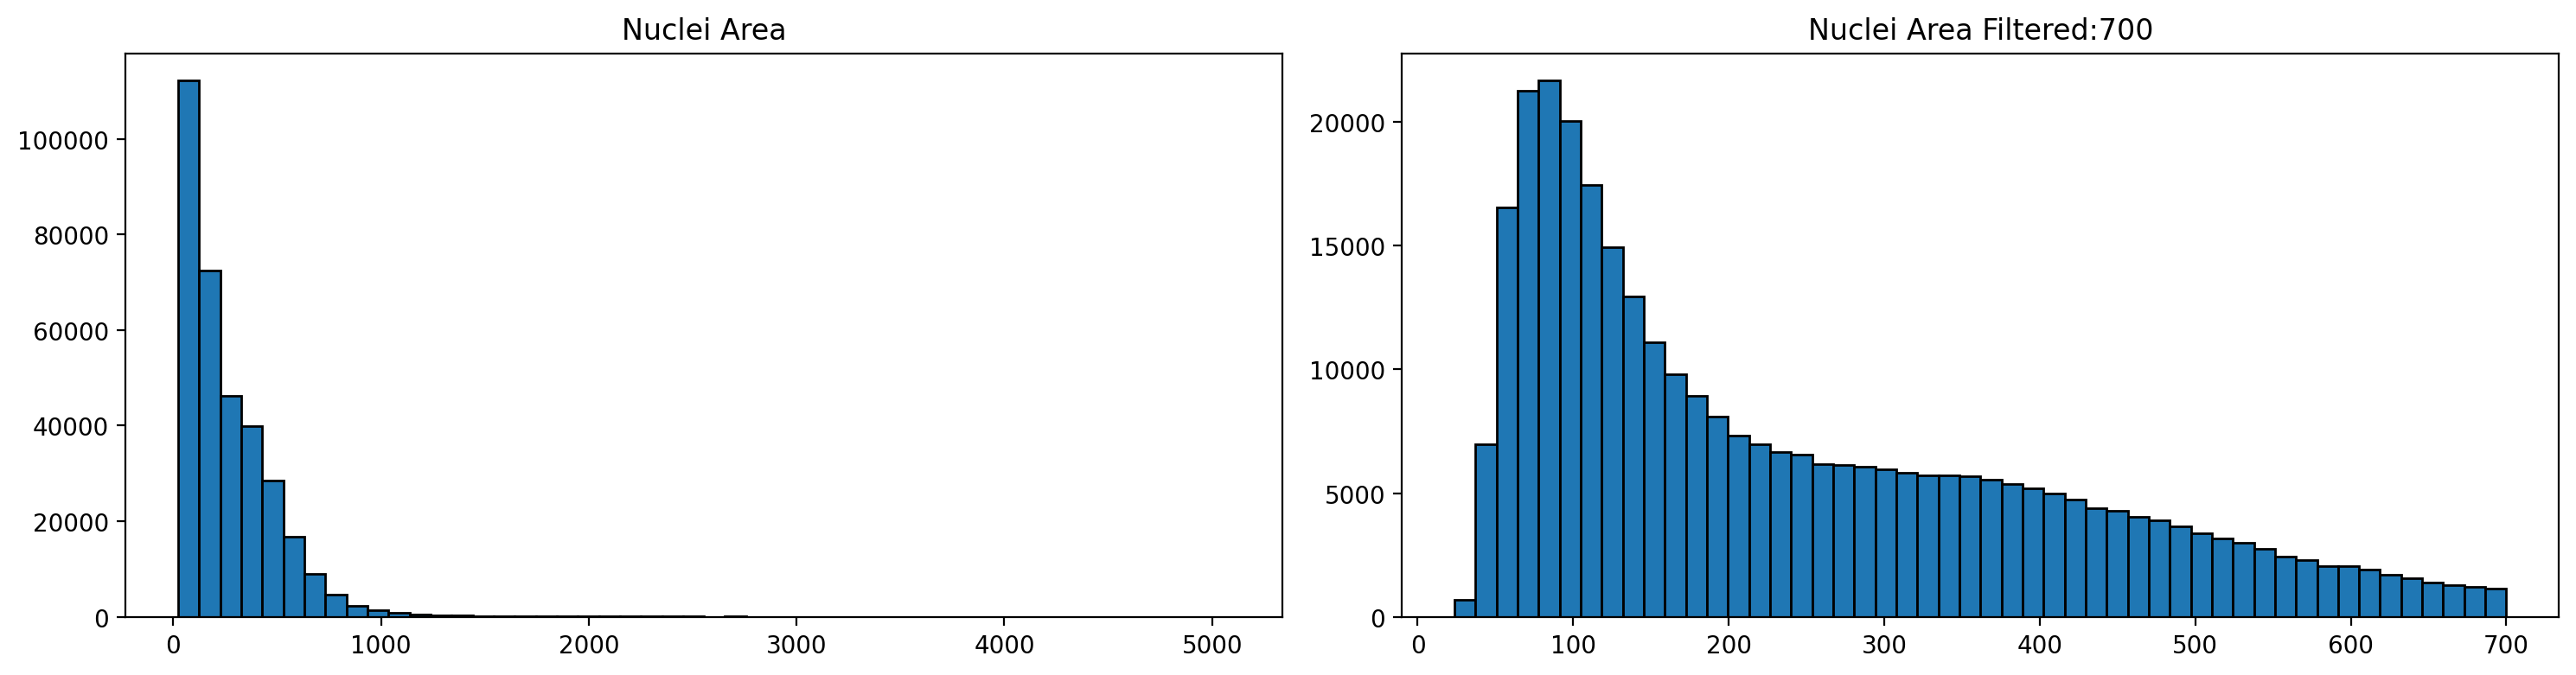

In [9]:
# Store the area of each nucleus in the GeoDataframe
gdf['area'] = gdf['geometry'].area

# Calculate quality control metrics for the original AnnData object
sc.pp.calculate_qc_metrics(grouped_filtered_adata, inplace=True)

# Plot the nuclei area distribution before and after filtering
plot_nuclei_area(gdf=gdf,area_cut_off=700)


In [10]:
# Create a mask based on the 'id' column for values present in 'gdf' with 'area' less than 500
mask_area = grouped_filtered_adata.obs['id'].isin(gdf[gdf['area'] < 700].id)

# Create a mask based on the 'total_counts' column for values greater than 100
mask_count = grouped_filtered_adata.obs['total_counts'] > 10

# Apply both masks to the original AnnData to create a new filtered AnnData object
count_area_filtered_adata = grouped_filtered_adata[mask_area & mask_count, :]


In [13]:
import scanpy as sc
import numpy as np
import pandas as pd # Ensure pandas is imported if not already
# Assuming geopandas was used earlier for gdf, but not strictly needed in this cell
# import geopandas as gpd
import os # Needed for dir_base construction
import traceback # For error handling
from scipy.sparse import issparse

# --- Configuration & Prior Steps (Ensure these are loaded/run first) ---
# Assume these variables exist from previous cells:
# grouped_filtered_adata: AnnData object *before* area/count filtering, containing raw counts
# gdf: Your GeoDataFrame with segmentation polygons ('id', 'geometry', 'area' columns)
# img: Your loaded image array (NumPy array)
# dir_base = "/path/to/your/data/" # Example: define your base directory
# filename = "your_image_filename.tif" # Example: define your image filename
# library_id = "Your_Library_ID" # Define your actual library ID

# --- Define Library ID ---
library_id = "16.5E-15.5E-14.5E_Segmented" # <<< Use your actual library ID here

# --- Filtering Section (Keep this part) ---
print("--- Applying Area and Count Filters ---")
# Ensure gdf 'id' type matches grouped_filtered_adata index type (often needs casting)
try:
    if grouped_filtered_adata.obs.index.dtype != gdf['id'].dtype:
        print(f"Casting gdf 'id' from {gdf['id'].dtype} to match AnnData index {grouped_filtered_adata.obs.index.dtype}")
        gdf['id'] = gdf['id'].astype(grouped_filtered_adata.obs.index.dtype)
except Exception as e:
    raise TypeError(f"Could not align gdf 'id' dtype with AnnData index dtype. Error: {e}")

# Create a mask based on the 'id' column for values present in 'gdf' with 'area' less than 700
mask_area = grouped_filtered_adata.obs.index.isin(gdf[gdf['area'] < 700]['id'])

# Create a mask based on the 'total_counts' column for values greater than 10
# Calculate total_counts first if it doesn't exist
if 'total_counts' not in grouped_filtered_adata.obs:
     print("Calculating initial total_counts...")
     grouped_filtered_adata.obs['total_counts'] = np.ravel(grouped_filtered_adata.X.sum(axis=1))
mask_count = grouped_filtered_adata.obs['total_counts'] > 10

# Apply both masks
count_area_filtered_adata = grouped_filtered_adata[mask_area & mask_count, :].copy() # Use .copy()
print(f"Shape after filtering: {count_area_filtered_adata.shape}")

# --- Preprocessing Section (REMOVED/SKIPPED) ---
print("\n--- Preprocessing Steps (QC, Normalize, Log, HVG, PCA, Neighbors, Cluster) SKIPPED ---")
# NO sc.pp.calculate_qc_metrics
# NO count_area_filtered_adata.raw = ...
# NO sc.pp.normalize_total
# NO sc.pp.log1p
# NO sc.pp.highly_variable_genes
# NO sc.pp.pca
# NO sc.pp.neighbors
# NO sc.tl.leiden
# count_area_filtered_adata.X still contains the filtered raw counts


# --- Spatial Finalization Section (Keep this part) ---
print("\n--- Finalizing AnnData with Spatial Information ---")
print(f"Using Library ID: {library_id}") # Make sure library_id is defined

# --- Check required variables exist ---
# Assuming gdf, img, dir_base, filename are available from previous scope
required_vars = ['count_area_filtered_adata', 'gdf', 'img', 'dir_base', 'filename', 'library_id']
for var_name in required_vars:
    if var_name not in locals() and var_name not in globals(): # Check both local and global scopes
        raise NameError(f"Required variable '{var_name}' not found. Ensure it's defined.")


# --- 1. Align gdf with the final AnnData object ---
print("\nStep 1: Aligning GeoDataFrame with AnnData...")
final_nuclei_ids = count_area_filtered_adata.obs.index
if 'id' not in gdf.columns: raise KeyError("'id' column missing in gdf.")
# Ensure types match before filtering (already done above, but double check is ok)
if gdf['id'].dtype != final_nuclei_ids.dtype:
     try: gdf['id'] = gdf['id'].astype(final_nuclei_ids.dtype)
     except Exception as e: raise TypeError(f"Could not cast gdf 'id'. Error: {e}")
aligned_gdf = gdf[gdf['id'].isin(final_nuclei_ids)].copy()
if aligned_gdf.empty: raise ValueError("Alignment resulted in empty GDF.")
aligned_gdf = aligned_gdf.set_index('id').loc[final_nuclei_ids] # Set index and reorder
print(f"Aligned GDF shape: {aligned_gdf.shape}")
assert aligned_gdf.shape[0] == count_area_filtered_adata.shape[0], "Row mismatch after alignment."
assert all(aligned_gdf.index == count_area_filtered_adata.obs.index), "Index mismatch after alignment."
print("Alignment successful.")


# --- 2. Calculate Centroids ---
print("\nStep 2: Calculating centroids...")
if 'geometry' not in aligned_gdf.columns: raise KeyError("'geometry' column missing.")
centroids = aligned_gdf.geometry.centroid
centroid_coords = np.array([[p.x, p.y] for p in centroids])
print(f"Calculated centroids shape: {centroid_coords.shape}")
assert centroid_coords.shape[0] == count_area_filtered_adata.shape[0], "Centroid count mismatch."
assert centroid_coords.shape[1] == 2, "Centroids should be 2D."
print("Centroid calculation successful.")


# --- 3. Add Centroids to adata.obsm['spatial'] ---
print("\nStep 3: Adding centroids to AnnData...")
count_area_filtered_adata.obsm['spatial'] = centroid_coords
print("Added centroids to adata.obsm['spatial']")

# --- 4. Add Polygon Geometries as WKT and Area to adata.obs ---
print("\nStep 4: Adding WKT geometries and area to AnnData observations...")
if 'geometry' in aligned_gdf.columns and hasattr(aligned_gdf.geometry, 'to_wkt'):
    count_area_filtered_adata.obs['geometry_wkt'] = aligned_gdf.geometry.to_wkt()
    print("Added 'geometry_wkt'.")
else: print("Warning: Could not add 'geometry_wkt'.")
if 'area' in aligned_gdf.columns:
     count_area_filtered_adata.obs['area'] = aligned_gdf['area']
     print("Added 'area'.")
else: print("Info: 'area' column not found in aligned_gdf.")

# --- 4.5 Explicitly remove any lingering 'geometry' column from obs ---
if 'geometry' in count_area_filtered_adata.obs.columns:
    try:
        is_geometry_dtype = pd.api.types.is_extension_array_dtype(count_area_filtered_adata.obs['geometry'].dtype) and \
                           'geometry' in str(count_area_filtered_adata.obs['geometry'].dtype).lower()
    except AttributeError:
        is_geometry_dtype = 'geometry' in str(type(count_area_filtered_adata.obs['geometry'].iloc[0])).lower() if not count_area_filtered_adata.obs.empty else False
    if is_geometry_dtype:
         print("WARN: Removing lingering 'geometry' column from obs.")
         del count_area_filtered_adata.obs['geometry']

# --- 5. Add Metadata AND IMAGE to adata.uns['spatial'] ---
print("\nStep 5: Adding metadata and embedding image into AnnData unstructured data...")
# Calculate spot diameter
spot_diameter = 10.0 # Default
# Use .obs['area'] from the AnnData object now
if 'area' in count_area_filtered_adata.obs and count_area_filtered_adata.obs['area'].notna().any() and count_area_filtered_adata.obs['area'][count_area_filtered_adata.obs['area'] > 0].shape[0] > 0:
     mean_area = count_area_filtered_adata.obs['area'][count_area_filtered_adata.obs['area'] > 0].mean()
     spot_diameter = np.sqrt(mean_area / np.pi) * 2
     print(f"Calculated spot diameter: {spot_diameter:.2f}")
else: print(f"Warning: Using default spot diameter: {spot_diameter}")

# Construct the spatial dictionary in uns
count_area_filtered_adata.uns['spatial'] = {
    library_id: {
        'images': {'hires': img.copy() }, # Embed image
        'scalefactors': {
            'tissue_hires_scalef': 1.0,
            'spot_diameter_fullres': spot_diameter
        },
        'metadata': {
             'source_image_path': os.path.join(dir_base, filename), # Use os.path.join
             'segmentation_method': 'StarDist2D_versatile_he',
             'image_status': f'embedded_dtype_{img.dtype}', # Image wasn't normalized here
             # Add any other relevant metadata
        }
    }
}
print(f"Added metadata and embedded image to adata.uns['spatial'] for library_id: {library_id}")


# --- 6. Inspection Step Before Saving ---
print("\nStep 6: Inspecting final AnnData before saving...")
print("Object Info:")
print(count_area_filtered_adata)
# Verify X contains raw counts (check min/max/dtype)
print(f"\nChecking final adata.X: dtype={count_area_filtered_adata.X.dtype}, min={count_area_filtered_adata.X.min():.2f}, max={count_area_filtered_adata.X.max():.2f}")
if np.all(np.equal(np.mod(count_area_filtered_adata.X.data if issparse(count_area_filtered_adata.X) else count_area_filtered_adata.X, 1), 0)):
     print("  adata.X appears to contain integer values (likely raw counts).")
else:
     print("  WARNING: adata.X contains non-integer values. Check filtering steps if raw counts were expected.")

print("\nObs Info:")
count_area_filtered_adata.obs.info()
print("\nObsm Keys:", list(count_area_filtered_adata.obsm.keys()))
print("\nUns Keys:", list(count_area_filtered_adata.uns.keys()))
if 'spatial' in count_area_filtered_adata.uns: print("Uns['spatial'] Keys:", list(count_area_filtered_adata.uns['spatial'].keys()))
# ... (add more specific checks if needed) ...


# --- 7. Save the final AnnData object ---
output_h5ad_path = os.path.join(dir_base, "segmented_nuclei_expression_spatial_RAW_Filtered.h5ad") # New name
print(f"\nStep 7: Saving final AnnData object...")
try:
    print(f"\nAttempting to save AnnData object to: {output_h5ad_path}")
    # The object now has filtered raw counts in .X
    count_area_filtered_adata.write_h5ad(output_h5ad_path, compression="gzip")
    print(f"\n--------------------------------------------------")
    print(f"Successfully saved final AnnData object.")
    print(f"  Path: {output_h5ad_path}")
    print(f"  Filtered raw counts are in .X")
    print(f"  Preprocessing/clustering steps were SKIPPED.")
    print(f"--------------------------------------------------")

except Exception as e:
    # (Keep your error handling)
    print(f"\n!!! ERROR during saving: {e} !!!"); traceback.print_exc()

print("\nAnnData finalization process complete.")

--- Applying Area and Count Filters ---


anndata.py (1756): Variable names are not unique. To make them unique, call `.var_names_make_unique`.


Shape after filtering: (273142, 19059)

--- Preprocessing Steps (QC, Normalize, Log, HVG, PCA, Neighbors, Cluster) SKIPPED ---

--- Finalizing AnnData with Spatial Information ---
Using Library ID: 16.5E-15.5E-14.5E_Segmented

Step 1: Aligning GeoDataFrame with AnnData...
Aligned GDF shape: (273142, 2)
Alignment successful.

Step 2: Calculating centroids...
Calculated centroids shape: (273142, 2)
Centroid calculation successful.

Step 3: Adding centroids to AnnData...
Added centroids to adata.obsm['spatial']

Step 4: Adding WKT geometries and area to AnnData observations...
Added 'geometry_wkt'.
Added 'area'.

Step 5: Adding metadata and embedding image into AnnData unstructured data...
Calculated spot diameter: 17.91
Added metadata and embedded image to adata.uns['spatial'] for library_id: 16.5E-15.5E-14.5E_Segmented

Step 6: Inspecting final AnnData before saving...
Object Info:
AnnData object with n_obs × n_vars = 273142 × 19059
    obs: 'id', 'n_genes_by_counts', 'log1p_n_genes_by_

In [20]:
import numpy as np
import pandas as pd # Ensure pandas is imported if not already
# Assuming geopandas was used earlier for gdf, but not strictly needed in this cell
# import geopandas as gpd

# --- Configuration (Likely defined in previous cells) ---
# Ensure these variables are defined and accessible in this scope:
# count_area_filtered_adata: Your filtered AnnData object
# gdf: Your GeoDataFrame with segmentation polygons ('id', 'geometry', 'area' columns)
# img: Your loaded (and potentially normalized) image as a NumPy array
# dir_base: Base directory path string
# filename: Original image filename string

# --- Define Library ID ---
library_id = "16.5E-15.5E-14.5E_Segmented" # <<< Use your actual library ID here

print("Starting AnnData finalization...")
print(f"Using Library ID: {library_id}")

# --- Check required variables exist ---
required_vars = ['count_area_filtered_adata', 'gdf', 'img', 'dir_base', 'filename']
for var_name in required_vars:
    if var_name not in locals():
        raise NameError(f"Required variable '{var_name}' not found in the current scope. "
                        f"Please ensure the cells defining it have been executed.")

# --- 1. Align gdf with the final AnnData object ---
print("\nStep 1: Aligning GeoDataFrame with AnnData...")
final_nuclei_ids = count_area_filtered_adata.obs.index
if not pd.api.types.is_string_dtype(final_nuclei_ids) and not pd.api.types.is_integer_dtype(final_nuclei_ids):
     # Convert index to string if it's not already, as GDF 'id' might be string
     print(f"Warning: AnnData index type is {final_nuclei_ids.dtype}, converting to string for alignment.")
     count_area_filtered_adata.obs.index = count_area_filtered_adata.obs.index.astype(str)
     final_nuclei_ids = count_area_filtered_adata.obs.index

if 'id' not in gdf.columns:
    raise KeyError("The GeoDataFrame 'gdf' must contain an 'id' column matching the AnnData observation index.")

# Ensure gdf 'id' column matches AnnData index type for reliable filtering
if gdf['id'].dtype != final_nuclei_ids.dtype:
     try:
          print(f"Attempting to cast gdf 'id' column from {gdf['id'].dtype} to {final_nuclei_ids.dtype} for alignment.")
          gdf['id'] = gdf['id'].astype(final_nuclei_ids.dtype)
     except Exception as e:
          raise TypeError(f"Could not cast gdf 'id' column to match AnnData index type ({final_nuclei_ids.dtype}). Error: {e}")


aligned_gdf = gdf[gdf['id'].isin(final_nuclei_ids)].copy()

# Check if alignment resulted in empty GeoDataFrame
if aligned_gdf.empty:
    raise ValueError("Alignment resulted in an empty GeoDataFrame. Check if 'id' values in gdf match AnnData obs index.")

# Set index and reorder
aligned_gdf = aligned_gdf.set_index('id')
try:
    aligned_gdf = aligned_gdf.loc[final_nuclei_ids]
except KeyError as e:
     missing_ids = set(final_nuclei_ids) - set(aligned_gdf.index)
     raise KeyError(f"KeyError during alignment. Some AnnData IDs were not found in the filtered GDF index. "
                    f"Example missing IDs: {list(missing_ids)[:5]}. Error: {e}")


print(f"Aligned GDF shape: {aligned_gdf.shape}")
print(f"Filtered AnnData shape: {count_area_filtered_adata.shape}")
assert aligned_gdf.shape[0] == count_area_filtered_adata.shape[0], "Number of rows in aligned GDF and AnnData must match."
assert all(aligned_gdf.index == count_area_filtered_adata.obs.index), "Indices of aligned GDF and AnnData obs must match perfectly."
print("Alignment successful.")

# --- 2. Calculate Centroids ---
print("\nStep 2: Calculating centroids...")
if 'geometry' not in aligned_gdf.columns:
     raise KeyError("The aligned GeoDataFrame 'aligned_gdf' is missing the 'geometry' column required for centroid calculation.")

centroids = aligned_gdf.geometry.centroid
centroid_coords = np.array([[p.x, p.y] for p in centroids])
print(f"Calculated centroids shape: {centroid_coords.shape}")
assert centroid_coords.shape[0] == count_area_filtered_adata.shape[0], "Number of centroids must match number of observations."
assert centroid_coords.shape[1] == 2, "Centroid coordinates should have 2 dimensions (x, y)."
print("Centroid calculation successful.")

# --- 3. Add Centroids to adata.obsm['spatial'] ---
print("\nStep 3: Adding centroids to AnnData...")
count_area_filtered_adata.obsm['spatial'] = centroid_coords
print("Added centroids to adata.obsm['spatial']")

# --- 4. Add Polygon Geometries as WKT and Area to adata.obs ---
print("\nStep 4: Adding WKT geometries and area to AnnData observations...")
# Convert geometries to Well-Known Text (WKT) strings for saving
# Check if 'geometry' column still exists and contains geometry objects
if 'geometry' in aligned_gdf.columns and hasattr(aligned_gdf.geometry, 'to_wkt'):
    count_area_filtered_adata.obs['geometry_wkt'] = aligned_gdf.geometry.to_wkt()
    print("Added 'geometry_wkt' (as WKT strings) to adata.obs")
else:
    print("Warning: Could not find valid 'geometry' column in aligned_gdf to generate WKT strings.")


# Add area if present in the aligned GDF
if 'area' in aligned_gdf.columns:
     count_area_filtered_adata.obs['area'] = aligned_gdf['area']
     print("Added 'area' to adata.obs")
else:
     print("Info: 'area' column not found in aligned_gdf, skipping.")

# --- 4.5 Explicitly remove any lingering 'geometry' column from obs ---
# This is crucial because saving an AnnData object with a column containing
# actual GeoPandas Geometry objects will often fail.
if 'geometry' in count_area_filtered_adata.obs.columns:
    # Check if it's actually a GeometryArray before deleting, just to be safe
    # We need to import pandas extensions API here if not already done
    try:
        is_geometry_dtype = pd.api.types.is_extension_array_dtype(count_area_filtered_adata.obs['geometry'].dtype) and \
                           'geometry' in str(count_area_filtered_adata.obs['geometry'].dtype).lower()
    except AttributeError:
        # Handle cases where pandas version might not have this specific API or dtype isn't standard
        print(f"WARN: Could not definitively check if 'geometry' column dtype is GeometryArray. Proceeding with caution.")
        is_geometry_dtype = 'geometry' in str(type(count_area_filtered_adata.obs['geometry'].iloc[0])).lower() if not count_area_filtered_adata.obs.empty else False


    if is_geometry_dtype:
         print("WARN: Found lingering 'geometry' column with GeometryArray objects in adata.obs. Removing it before saving.")
         del count_area_filtered_adata.obs['geometry']
    else:
         print(f"INFO: Found a column named 'geometry' in adata.obs, but its dtype is {count_area_filtered_adata.obs['geometry'].dtype}. Leaving it alone.")


# --- 5. Add Metadata AND IMAGE to adata.uns['spatial'] ---
print("\nStep 5: Adding metadata and embedding image into AnnData unstructured data...")
print("Embedding image array into adata.uns['spatial'][library_id]['images']['hires']...")
print(f"INFO: Image details - Shape: {img.shape}, Dtype: {img.dtype}")
print("WARNING: Embedding the full image array can significantly increase the .h5ad file size and loading time.")

# Calculate spot diameter for scale factors
# Ensure calculation is robust even if area column is missing or has non-positive values
spot_diameter = 10.0 # Default value
if 'area' in aligned_gdf.columns and aligned_gdf['area'].notna().any() and aligned_gdf['area'].mean() > 0:
     mean_area = aligned_gdf['area'][aligned_gdf['area'] > 0].mean() # Calculate mean only on positive areas
     spot_diameter = np.sqrt(mean_area / np.pi) * 2
     print(f"Calculated spot diameter based on mean area: {spot_diameter:.2f}")
else:
    print(f"Warning: Could not calculate spot diameter from 'area' column. Using default value: {spot_diameter}")


# Construct the spatial dictionary in uns
count_area_filtered_adata.uns['spatial'] = {
    library_id: {
        # Embed the actual image NumPy array here
        'images': {'hires': img.copy() }, # Use a copy to avoid modifying original img if adata is manipulated later
        'scalefactors': {
            'tissue_hires_scalef': 1.0, # Assuming image is high-res
            'spot_diameter_fullres': spot_diameter
        },
        'metadata': {
             'source_image_path': dir_base + filename, # Still useful to keep path for reference
             'segmentation_method': 'StarDist2D_versatile_he', # Or your method
             'image_status': f'normalized_embedded_dtype_{img.dtype}' # Describe the embedded image
             # Add any other relevant metadata here
        }
    }
}
# Add the library_id key directly to adata.uns - standard practice now
# count_area_filtered_adata.uns['spatial']['library_id'] = library_id # No longer the preferred way

print(f"Added metadata and embedded image to adata.uns['spatial'] for library_id: {library_id}")


# --- 6. Inspection Step Before Saving ---
print("\nStep 6: Inspecting adata.obs columns and types right before saving:")
print("--------------------------------------------------")
count_area_filtered_adata.obs.info()
print("--------------------------------------------------")
print("\nInspecting adata.obsm keys:")
print(list(count_area_filtered_adata.obsm.keys()))
print("\nInspecting adata.uns keys:")
print(list(count_area_filtered_adata.uns.keys()))
if 'spatial' in count_area_filtered_adata.uns:
    print("\nInspecting adata.uns['spatial'] keys:")
    print(list(count_area_filtered_adata.uns['spatial'].keys()))
    if library_id in count_area_filtered_adata.uns['spatial']:
        print(f"\nInspecting adata.uns['spatial']['{library_id}'] keys:")
        print(list(count_area_filtered_adata.uns['spatial'][library_id].keys()))
        if 'images' in count_area_filtered_adata.uns['spatial'][library_id]:
             print(f"\nInspecting adata.uns['spatial']['{library_id}']['images'] keys:")
             print(list(count_area_filtered_adata.uns['spatial'][library_id]['images'].keys()))
             if 'hires' in count_area_filtered_adata.uns['spatial'][library_id]['images']:
                  print(f"adata.uns['spatial']['{library_id}']['images']['hires'] type: {type(count_area_filtered_adata.uns['spatial'][library_id]['images']['hires'])}")
                  print(f"adata.uns['spatial']['{library_id}']['images']['hires'] shape: {count_area_filtered_adata.uns['spatial'][library_id]['images']['hires'].shape}")
                  print(f"adata.uns['spatial']['{library_id}']['images']['hires'] dtype: {count_area_filtered_adata.uns['spatial'][library_id]['images']['hires'].dtype}")
print("--------------------------------------------------")


# --- 7. Save the final AnnData object ---
output_h5ad_path = dir_base + "segmented_nuclei_expression_spatial.h5ad" # Choose your final output name
print(f"\nStep 7: Saving final AnnData object...")
try:
    print(f"\nAttempting to save AnnData object to: {output_h5ad_path}")
    count_area_filtered_adata.write_h5ad(output_h5ad_path, compression="gzip")
    print(f"\n--------------------------------------------------")
    print(f"Successfully saved final AnnData object with spatial information to:")
    print(output_h5ad_path)
    print(f"--------------------------------------------------")

except Exception as e:
    print(f"\n!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!")
    print(f"ERROR during saving AnnData object: {e}")
    print(f"!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!")
    print("\nRe-inspecting adata.obs columns and types AFTER error:")
    print("--------------------------------------------------")
    count_area_filtered_adata.obs.info()
    print("--------------------------------------------------")
    # Optionally, add more debugging info here if needed
    import traceback
    print("\nTraceback:")
    traceback.print_exc()
    print("--------------------------------------------------")


print("\nAnnData finalization process complete.")

Starting AnnData finalization...
Using Library ID: 16.5E-15.5E-14.5E_Segmented

Step 1: Aligning GeoDataFrame with AnnData...
Aligned GDF shape: (273142, 2)
Filtered AnnData shape: (273142, 19059)
Alignment successful.

Step 2: Calculating centroids...
Calculated centroids shape: (273142, 2)
Centroid calculation successful.

Step 3: Adding centroids to AnnData...
Added centroids to adata.obsm['spatial']

Step 4: Adding WKT geometries and area to AnnData observations...
Added 'geometry_wkt' (as WKT strings) to adata.obs
Added 'area' to adata.obs

Step 5: Adding metadata and embedding image into AnnData unstructured data...
Embedding image array into adata.uns['spatial'][library_id]['images']['hires']...
INFO: Image details - Shape: (35908, 30034, 3), Dtype: float32
Calculated spot diameter based on mean area: 17.91
Added metadata and embedded image to adata.uns['spatial'] for library_id: 16.5E-15.5E-14.5E_Segmented

Step 6: Inspecting adata.obs columns and types right before saving:
---

anndata.py (1756): Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.7253521..1.0704225].


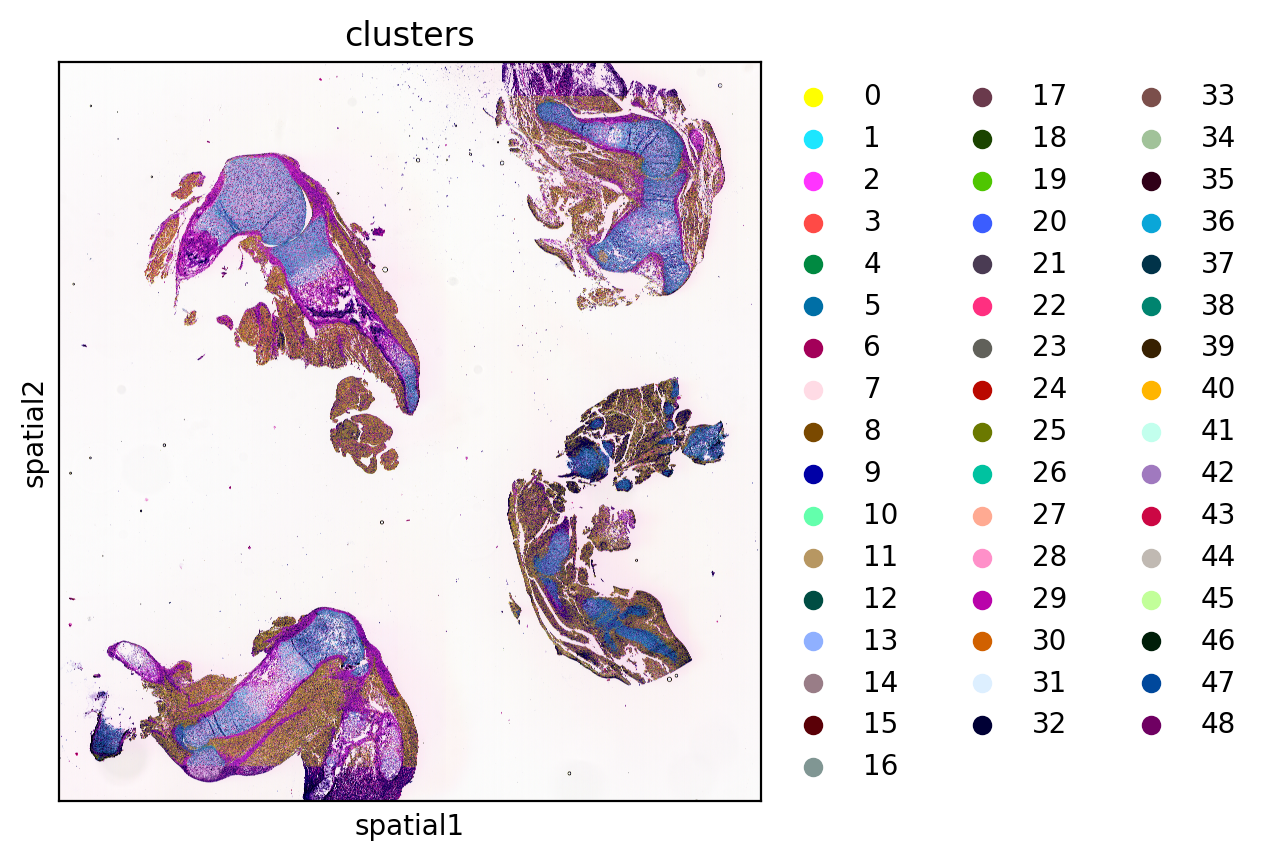

In [21]:
# Load the data
loaded_adata = sc.read_h5ad(output_h5ad_path)
loaded_adata.var_names_make_unique()

sc.pl.spatial(loaded_adata, color='clusters')

In [ ]:
# check the inported segmented_nuclei hires image

import scanpy as sc
import matplotlib.pyplot as plt
import numpy as np # Often needed with image data

# --- Configuration ---
# Make sure output_h5ad_path is still defined from your saving step
# Make sure library_id matches the one used during saving
library_id = "16.5E-15.5E-14.5E_Segmented" # <<< Use your actual library ID

# --- Load the data ---
print(f"Loading AnnData from: {output_h5ad_path}")
loaded_adata = sc.read_h5ad(output_h5ad_path)
loaded_adata.var_names_make_unique()
print("AnnData loaded.")

# --- Check Y coordinate range ---
y_coords = loaded_adata.obsm['spatial'][:, 1]
print(f"Y coordinate range: {y_coords.min()} {y_coords.max()}")

# --- *** Extract the embedded image *** ---
try:
    print(f"Extracting image for library ID: {library_id}")
    # Use the correct library_id you defined
    embedded_img = loaded_adata.uns['spatial'][library_id]['images']['lowres']
    print(f"Successfully extracted embedded image. Shape: {embedded_img.shape}, Dtype: {embedded_img.dtype}")

    # --- Display the embedded image ---
    plt.figure(figsize=(8, 8)) # Adjust figure size if needed
    plt.imshow(embedded_img)
    plt.title(f"Embedded Image Array (from {library_id})")
    plt.xlabel("Image Width (pixels)")
    plt.ylabel("Image Height (pixels)")
    plt.show()

except KeyError:
    print(f"ERROR: Could not find the image in AnnData.")
    print(f"Please check: ")
    print(f"  1. If the library ID '{library_id}' is correct.")
    print(f"  2. If the image was successfully embedded under uns['spatial']['{library_id}']['images']['hires']")
    print(f"Available keys in loaded_adata.uns: {list(loaded_adata.uns.keys())}")
    if 'spatial' in loaded_adata.uns:
        print(f"Available keys in loaded_adata.uns['spatial']: {list(loaded_adata.uns['spatial'].keys())}")
        if library_id in loaded_adata.uns['spatial']:
             print(f"Available keys in loaded_adata.uns['spatial']['{library_id}']: {list(loaded_adata.uns['spatial'][library_id].keys())}")
             if 'images' in loaded_adata.uns['spatial'][library_id]:
                  print(f"Available keys in loaded_adata.uns['spatial']['{library_id}']['images']: {list(loaded_adata.uns['spatial'][library_id]['images'].keys())}")

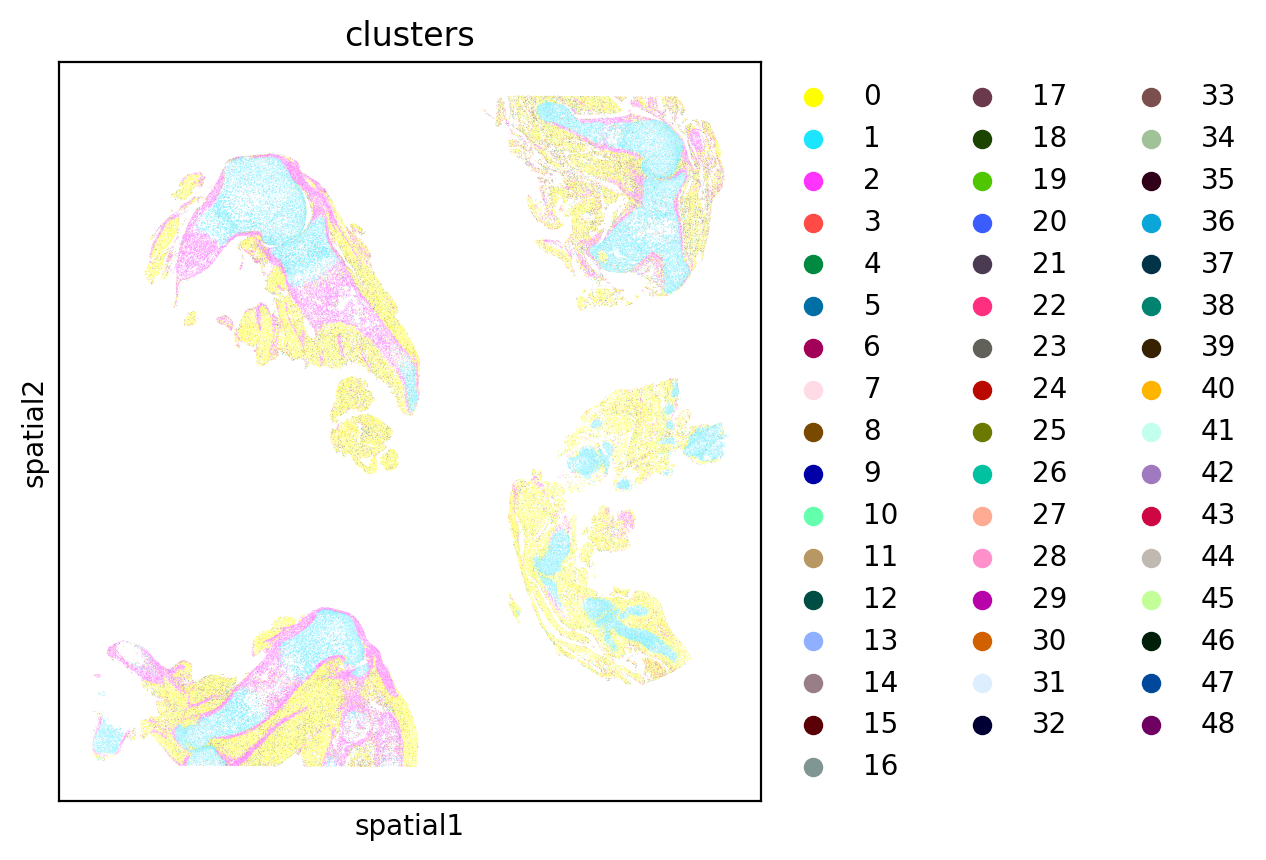

In [23]:
# Plot without trying to load a background image
sc.pl.spatial(loaded_adata,
              color='clusters',
              spot_size=None,
              img_key=None,
             save = 'e14_e15_e16_segmented.pdf') # Explicitly disable background image loading